## Analysis of Retail Data

**Henry Wang**

**henrymw@vt.edu**

In [1]:
import warnings # ignore warnings in notebook
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# Show plots
%matplotlib inline

### Part 1-Profit Margins, Monthly & Quarterly Aggregate Gross Revenue

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
0,1,1,TX,48628171.02,9218156.69,24278189.23,365880,4452,False
1,1,2,TX,48107179.24,10587747.35,25116844.41,365880,4452,False
2,1,3,TX,64352278.29,10193873.77,33703499.83,365880,4452,False
3,1,4,TX,45943677.96,8764165.00,24037719.47,365880,4452,False
4,1,5,TX,32761434.98,8022116.43,16432119.18,365880,4452,False


In [3]:
print(f'Rows = {int(data.shape[0]/12)}')
print(f'Cols = {data.shape[1]}')

Rows = 333
Cols = 9


In [4]:
print(data.columns)

Index(['Location number', 'Month', 'State', 'Gross revenue', 'Fixed cost',
       'Variable cost', 'Rental cost', 'Number of products', 'Owned'],
      dtype='object')


Let's define some of these columns in layman's terms:

* Gross revenue: total sales generated before factoring in expenses such as fixed, variable, and rental costs
* Fixed cost: business expenses (usually related to overhead)
* Variable cost: business expenses that scale
* Rental cost: amount needed to rent the place (this is not factored into fixed/variable costs)

Let's also define profit margins as a percentage:

$\text{annual profit margin} = \frac{\text{annual gross revenue} - \text{annual fixed costs} - \text{annual variable costs} - \text{annual rental costs}}{\text{annual gross revenue}} * 100$

Profit margins are a metric used by business to determine how much money stays in the business.

In [5]:
# Aggregate with sum so we get annual data for each location 
# and select the columns we need to calculate profit margins
cols = ['Location number', 'Gross revenue', 'Fixed cost', 'Variable cost', 'Rental cost']
df = data[cols].groupby(by='Location number').sum()
df.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost
Location number,,,,
1,5.447389e+08,1.108956e+08,2.793687e+08,4390560
2,3.559730e+08,7.287395e+07,1.937291e+08,783240
3,3.317718e+08,6.429775e+07,1.848279e+08,0
4,2.639843e+08,6.410409e+07,1.432398e+08,1696920
5,1.890016e+08,4.475050e+07,1.037553e+08,894000


In [6]:
df['Profit margins'] = (df['Gross revenue'] - df['Fixed cost'] - df['Variable cost'] - df['Rental cost']) / (df['Gross revenue']) * 100
df.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost,Profit margins
Location number,,,,,
1,5.447389e+08,1.108956e+08,2.793687e+08,4390560,27.551553
2,3.559730e+08,7.287395e+07,1.937291e+08,783240,24.885798
3,3.317718e+08,6.429775e+07,1.848279e+08,0,24.910550
4,2.639843e+08,6.410409e+07,1.432398e+08,1696920,20.813164
5,1.890016e+08,4.475050e+07,1.037553e+08,894000,20.953145


#### Profit Margins - Summary Statistics

In [7]:
def calc_summary(df):
    profit_margins = df['Profit margins']
    mean = round(profit_margins.mean(), 2)
    median = round(profit_margins.median(), 2)
    print(f'Mean of annual profit margins is {mean}%')
    print(f'Median of annual profit margins is {median}%')

calc_summary(df)

Mean of annual profit margins is 24.86%
Median of annual profit margins is 26.18%


In a normal distribution the mean and median should be equal. In this case, they are not. Let's take a closer look with some visualizations.

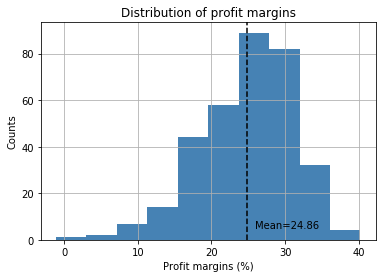

In [8]:
def plot_margins(df):
    profit_margins = df['Profit margins']
    ax = profit_margins.hist(color='steelblue')
    ax.set_title('Distribution of profit margins')
    ax.set_xlabel('Profit margins (%)')
    ax.set_ylabel('Counts')
    # visualize the mean as well
    plt.axvline(profit_margins.mean(), linestyle='dashed', color='black')
    plt.text(profit_margins.mean() + 1, 5, f'Mean={round(profit_margins.mean(), 2)}')
    plt.show()

plot_margins(df)

From a visual inspection of the distribution, the profit margins are not normally distributed because the data is not symmetric about the mean. Instead, the data appears to be left-skewed. We can also inspect our findings analytically with hypothesis testing. Here, we use a normality [test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html) where $H_0:$ the distribution of annual profit margins across all locations comes from a normal distribution. 

In [9]:
def normality_test(df):
    profit_margins = df['Profit margins']
    statistic, p_value = scipy.stats.normaltest(profit_margins)
    print(f'p={p_value}, with statistic={round(statistic, 2)}')    

normality_test(df)

p=1.2769717598779038e-07, with statistic=31.75


With $\alpha=0.05$, $p=1.2769717598779038\mathrm{e}{-07} < \alpha = 0.05$, we can reject the null hypothesis and say the annual profit margins data is not normally distributed.

#### Monthly & Quarterly Aggregate Gross Revenue

We need to aggregate the retail data by month/quarter instead of location.

Let's define some terms:

* Q1: quarter 1 of the year includes January, February, and March
* Q2: quarter 2 of the year includes April, May, and June
* Q3: quarter 3 of the year includes July, August, and September
* Q4: quarter 4 of the year includes October, November, and December

In [10]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
cols = ['Month', 'Gross revenue']
# sum revenues grouped by month
monthly_data = data[cols].groupby(by='Month').sum()
num_to_month_dict = dict(zip(range(1, 13), months))
# re-map index from 1 -> January, 2 -> February, ..., 12 -> December
monthly_data.index = monthly_data.index.map(num_to_month_dict)

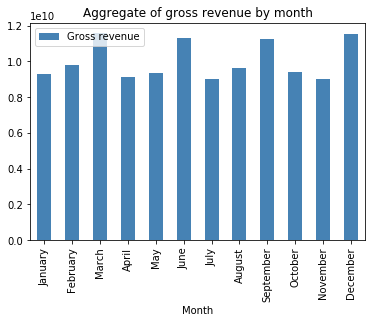

In [11]:
# Plot aggregate of gross revenue by month
ax = monthly_data.plot.bar(color='steelblue')
ax.set_title('Aggregate of gross revenue by month')

plt.show()

In [12]:
# To calculate the quarterly aggregates, we need to assign a label that indicates Q1, Q2, Q3, Q4.
# for a month m, let's define month_to_quarter(m) -> 1 if in quarter 1, 2 if in quarter 2, etc

def month_to_quarter(month):
    """Returns the proper quarter that this month belongs to
    """
    if month in ('January', 'February', 'March'):
        return 1
    elif month in ('April', 'May', 'June'):
        return 2
    elif month in ('July', 'August', 'September'):
        return 3
    else: # October, November, December
        return 4


quarterly_data = monthly_data.copy()
quarterly_data['Quarter'] = quarterly_data.index.map(month_to_quarter)
# sum revenues grouped by quarter
quarterly_data = quarterly_data.groupby(by='Quarter').sum()
quarterly_data.head()

,Gross revenue
Quarter,
1,3.067833e+10
2,2.975031e+10
3,2.988107e+10
4,2.993717e+10


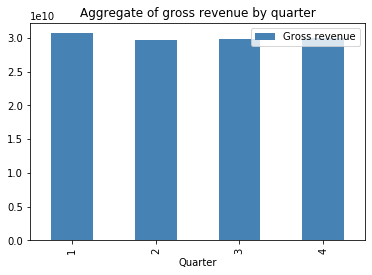

In [13]:
# Plot aggregate of gross revenue by quarter
ax = quarterly_data.plot.bar(color='steelblue')
ax.set_title('Aggregate of gross revenue by quarter')

plt.show()

### Part 2-Cleaning Data

Some locations are owned, while others are rented which affects our analysis from above.

In [14]:
disp_df = data.groupby(by='Location number').sum()[['Gross revenue', 'Rental cost', 'Owned']]

disp_df['Owned'] = disp_df['Owned'].map(bool)

disp_df.head()

,Gross revenue,Rental cost,Owned
Location number,,,
1,5.447389e+08,4390560,False
2,3.559730e+08,783240,False
3,3.317718e+08,0,True
4,2.639843e+08,1696920,False
5,1.890016e+08,894000,False


Let's impute the annual rental cost of owned locations (rent = 0) with the mean of annual rental costs of leased locations (rent > 0).

In [15]:
# Grab all locations that are leased, aggregate rent for each month to get an annual cost for rent
# then take an average
imputed_mean = data[data['Owned'] == False].groupby('Location number').sum()['Rental cost'].mean()
imputed_mean

1987522.0202020202

Now, we can re-run our analysis of annual profit margins.

In [16]:
# Aggregate by location so we get annual data, and select the columns we need to calculate profit margins
cols = ['Location number', 'Gross revenue', 'Fixed cost', 'Variable cost', 'Rental cost']
new_df = data[cols].groupby(by='Location number').sum()
# Impute the annual rental cost of owned locations with the average annual cost of leased locations
new_df['Rental cost'] = new_df['Rental cost'].replace(to_replace=0, value=imputed_mean)
new_df.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost
Location number,,,,
1,5.447389e+08,1.108956e+08,2.793687e+08,4.390560e+06
2,3.559730e+08,7.287395e+07,1.937291e+08,7.832400e+05
3,3.317718e+08,6.429775e+07,1.848279e+08,1.987522e+06
4,2.639843e+08,6.410409e+07,1.432398e+08,1.696920e+06
5,1.890016e+08,4.475050e+07,1.037553e+08,8.940000e+05


In [17]:
# Recalculate profit margins
new_df['Profit margins'] = (new_df['Gross revenue'] - new_df['Fixed cost'] - new_df['Variable cost'] - new_df['Rental cost']) / (new_df['Gross revenue']) * 100
new_df.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost,Profit margins
Location number,,,,,
1,5.447389e+08,1.108956e+08,2.793687e+08,4.390560e+06,27.551553
2,3.559730e+08,7.287395e+07,1.937291e+08,7.832400e+05,24.885798
3,3.317718e+08,6.429775e+07,1.848279e+08,1.987522e+06,24.311487
4,2.639843e+08,6.410409e+07,1.432398e+08,1.696920e+06,20.813164
5,1.890016e+08,4.475050e+07,1.037553e+08,8.940000e+05,20.953145


In [18]:
# Recalculate summary statistics
calc_summary(new_df)

Mean of annual profit margins is 24.81%
Median of annual profit margins is 26.02%


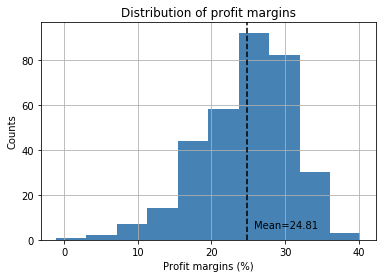

In [19]:
# Re-plot profit margins
plot_margins(new_df)

In [20]:
normality_test(new_df)

p=1.2274357217429496e-07, with statistic=31.83


The profit margins, after imputing the mean of annual rent of owned locations, is still not normally distributed because we reject $H_0$ ($p < \alpha = 0.05$).

### Part 3-Drivers of Success

In [21]:
# Add in state, number of products and ownership status to our augmented dataset
total_data = new_df.merge(
    data[['Location number', 'State', 'Number of products', 'Owned']].drop_duplicates(subset='Location number'),
    how='inner',
    left_on='Location number',
    right_on='Location number'
)

total_data.head()

,Location number,Gross revenue,Fixed cost,Variable cost,Rental cost,Profit margins,State,Number of products,Owned
0,1,5.447389e+08,1.108956e+08,2.793687e+08,4.390560e+06,27.551553,TX,4452,False
1,2,3.559730e+08,7.287395e+07,1.937291e+08,7.832400e+05,24.885798,TX,4502,False
2,3,3.317718e+08,6.429775e+07,1.848279e+08,1.987522e+06,24.311487,IL,4620,True
3,4,2.639843e+08,6.410409e+07,1.432398e+08,1.696920e+06,20.813164,GA,4481,False
4,5,1.890016e+08,4.475050e+07,1.037553e+08,8.940000e+05,20.953145,NJ,4533,False


Now, with our augmented dataset that includes annual profit margins we can take a closer look at the best performing locations when considering annual profit margins as our metric.

In [22]:
total_data.sort_values(by='Profit margins', ascending=False).head(10)

,Location number,Gross revenue,Fixed cost,Variable cost,Rental cost,Profit margins,State,Number of products,Owned
197,198,2.699811e+08,5.340702e+07,1.058644e+08,2.171040e+06,40.202291,WA,4694,False
232,233,5.602164e+08,9.715260e+07,2.573850e+08,6.240000e+04,36.703036,TX,4778,False
117,118,9.660039e+08,1.499075e+08,4.630773e+08,3.715680e+06,36.159635,TX,4726,False
8,9,8.129180e+08,1.403155e+08,3.780220e+08,1.987522e+06,35.992930,CA,4789,True
270,271,2.665627e+08,5.226988e+07,1.197077e+08,1.114440e+06,35.065163,TX,4637,False
51,52,5.168777e+08,9.143620e+07,2.449903e+08,8.316000e+05,34.750892,TX,4736,False
299,300,1.088825e+09,1.706193e+08,5.395776e+08,1.987522e+06,34.591482,TX,4736,True
243,244,4.938414e+08,8.836337e+07,2.337480e+08,1.004040e+06,34.571013,CA,4747,False
80,81,5.435426e+08,8.464220e+07,2.690534e+08,1.987522e+06,34.562044,TX,4767,True
199,200,3.705961e+08,6.226669e+07,1.791521e+08,2.350080e+06,34.222492,CA,4654,False


Correlation values close to -1 or 1 for any two variables indicates we should take a closer look at those two variables. In this case, we are interested in relationships between features other than profit margins correlated with profit margins.

In [23]:
cols = ['Gross revenue', 
         'Fixed cost', 
         'Variable cost', 
         'Rental cost', 
         'Profit margins', 
         'Owned',
         'Number of products']
total_data[cols].corr().sort_values(by='Profit margins', ascending=False)[['Profit margins']]

,Profit margins
Profit margins,1.000000
Number of products,0.802814
Gross revenue,0.483617
Variable cost,0.398386
Fixed cost,0.310592
Owned,0.185413
Rental cost,0.179626


We can see that `Number of products` and `Profit margins` has a high correlation value of $0.802814$.

The scatterplot between the two variables also shows a positive trend, which indicates this is an predictor worth looking into. Let's verify this relationship with a linear regression analysis.

In [24]:
X = total_data[['Number of products']]
y = total_data[['Profit margins']]
X_train, X_test, Y_train, Y_test = train_test_split(X, y)

In [25]:
linreg = LinearRegression()
linreg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

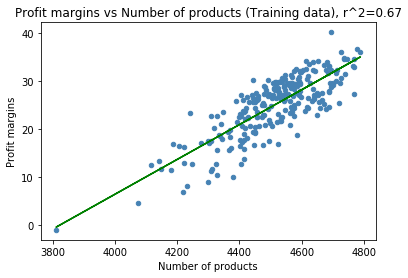

In [26]:
def plot_linreg(model, X, Y, title=''):    
    linreg_train_df = X.join(Y)
    r_sq = round(linreg.score(X, Y), 2)

    ax = linreg_train_df.plot.scatter(x='Number of products', y='Profit margins', color='steelblue')
    ax.plot(X, model.predict(X), color='green')
    ax.set_title(f'Profit margins vs Number of products ({title}), r^2={r_sq}')
    
    
plot_linreg(linreg, X_train, Y_train, title='Training data')

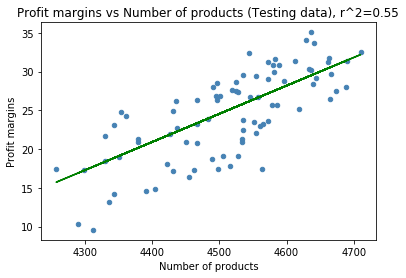

In [27]:
plot_linreg(linreg, X_test, Y_test, title='Testing data')

Stores that had higher number of products had in turn higher profit margins. Increasing product variety and availability could boost revenue and lead to higher profit margins.

When working with companies that have multiple locations, sometimes underlying geographical features could be a reason why one location sees higher profit margins annually over another.

In [28]:
print(set(total_data['State']))

{'IL', 'GA', 'CA', 'CO', 'TX', 'WA', 'NJ'}


Our dataset includes info about stores in all [regions](https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States) of the U.S.:

* West: Colorado, Washington
* Midwest: Illinois
* South: Texas, Georgia
* Northeast: New Jersey

In [29]:
regions = {
    'CO': 'West',
    'WA': 'West',
    'IL': 'Midwest',
    'TX': 'South',
    'CA': 'West',
    'NJ': 'Northeast',
    'GA': 'South'
}

Let's label our store locations by region.

In [30]:
total_data['Region'] = total_data['State'].map(regions)
total_data.head()

,Location number,Gross revenue,Fixed cost,Variable cost,Rental cost,Profit margins,State,Number of products,Owned,Region
0,1,5.447389e+08,1.108956e+08,2.793687e+08,4.390560e+06,27.551553,TX,4452,False,South
1,2,3.559730e+08,7.287395e+07,1.937291e+08,7.832400e+05,24.885798,TX,4502,False,South
2,3,3.317718e+08,6.429775e+07,1.848279e+08,1.987522e+06,24.311487,IL,4620,True,Midwest
3,4,2.639843e+08,6.410409e+07,1.432398e+08,1.696920e+06,20.813164,GA,4481,False,South
4,5,1.890016e+08,4.475050e+07,1.037553e+08,8.940000e+05,20.953145,NJ,4533,False,Northeast


Now, let's take a closer look at the data for each region.

In [31]:
# Summary statistics
stats = total_data[['Region', 'Profit margins']].groupby(by='Region').describe()
stats

Profit margins                                             \
                   count       mean       std        min        25%   
Region                                                                
Midwest             54.0  25.015216  5.288255  11.403469  22.448744   
Northeast           32.0  19.467070  5.479577   6.852616  16.931469   
South              155.0  25.305733  6.109641   8.821963  21.915864   
West                92.0  25.709383  6.341897  -1.084224  22.512487   

                                            
                 50%        75%        max  
Region                                      
Midwest    26.388885  28.586611  33.259537  
Northeast  19.894504  23.813142  29.196510  
South      26.659936  29.677847  36.703036  
West       26.420305  29.725345  40.202291

In [32]:
bucketed = total_data.join(pd.cut(total_data['Profit margins'], [-10, 0, 10, 20, 30, 40, 50]).rename('Profit margin bucket'))
bucketed.pivot_table(index='Region', columns='Profit margin bucket', aggfunc='size').fillna(0)

Profit margin bucket,"(-10, 0]","(0, 10]","(10, 20]","(20, 30]","(30, 40]","(40, 50]"
Region,,,,,,
Midwest,0.0,0.0,9.0,36.0,9.0,0.0
Northeast,0.0,3.0,13.0,16.0,0.0,0.0
South,0.0,2.0,27.0,94.0,32.0,0.0
West,1.0,1.0,13.0,56.0,20.0,1.0


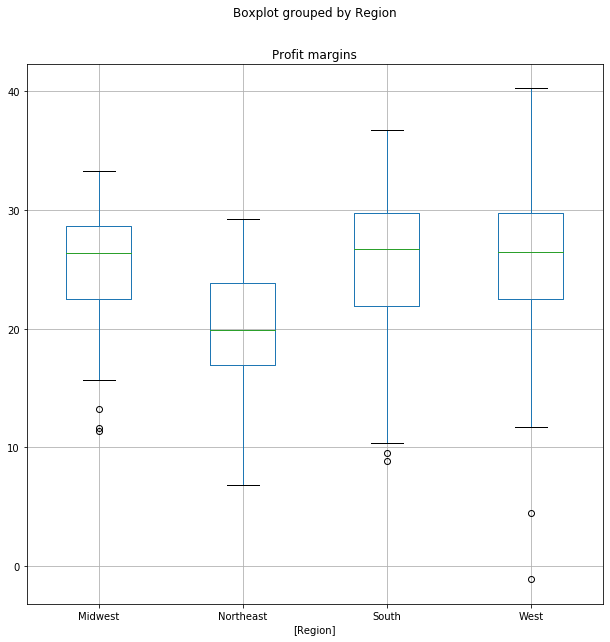

In [33]:
total_data[['Region', 'Profit margins']].boxplot(by='Region', figsize=(10,10))

We can see from this chart that the Northeast region underperformed compared to the Midwest, South and Western regions of stores. This could be for a number of reasons, and with some additional data perhaps on marketing strategies or audiences we can make more informed inferences. For now, it is clear though that geography and number of products of a store plays a role in annual profit margins.